In [1]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

In [2]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()
items_df.count()

item_id         12067
content_type    12067
title           12067
title_orig       9144
release_year    12019
genres          12067
countries       12051
for_kids          528
age_rating      12066
studios           749
directors       11160
actors          10268
description     12066
keywords        11705
dtype: int64

In [3]:
print(f"Число тренировочных интеракций: {len(train_part):,}")
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тренировочных интеракций: 1,224,560
Число тестовых пользователей: 18,693


user_id                                  ground_truth
0       30                           [8584, 3031, 15363]
1      144                          [3800, 11987, 10942]
2      241                    [14841, 6162, 5808, 15266]
3      259  [16509, 10509, 4491, 5434, 4471, 10772, 817]
4      475                            [6214, 3734, 6686]

EDA

In [4]:
users_df.head()

user_id        age        income sex  kids_flg
0   973171  age_25_34  income_60_90   М         1
1   962099  age_18_24  income_20_40   М         0
2   721985  age_45_54  income_20_40   Ж         0
3   704055  age_35_44  income_60_90   Ж         0
4   846063  age_35_44  income_40_60   Ж         1

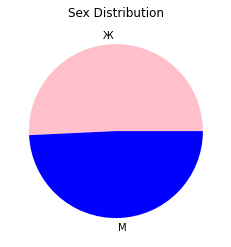

In [5]:
plt.pie((users_df['sex']).value_counts(), labels=users_df['sex'].value_counts().index, colors=['pink', 'blue'])
plt.title('Sex Distribution')
plt.show()

c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


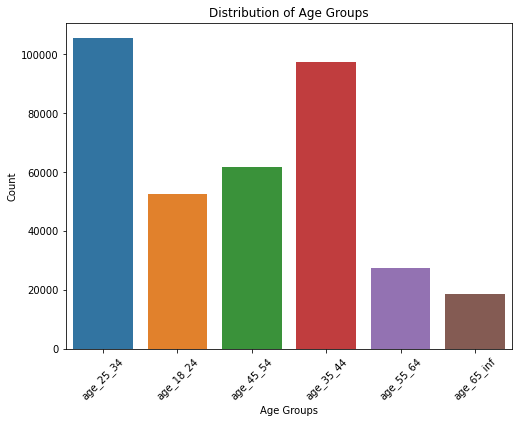

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=users_df, x=users_df['age'])
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=users_df, x=users_df['income'])
plt.title('Distribution of Income Levels')
plt.xlabel('Income Levels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\BADR-313\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


In [8]:
items_df.head()

item_id content_type                                  title  \
0    10711         film                         Поговори с ней   
1     2508         film                            Голые перцы   
2    10716         film                       Тактическая сила   
3     7868         film                                 45 лет   
4    11114         film  Принцесса Лебедь: Пират или принцесса   

                                          title_orig  release_year  \
0                                     Hable con ella        2002.0   
1                                       Search Party        2014.0   
2                                     Tactical Force        2011.0   
3                                           45 Years        2015.0   
4  The Swan Princess: Princess Tomorrow, Pirate T...        2016.0   

                                              genres       countries  \
0            драмы, зарубежные, детективы, мелодрамы         Испания   
1                   зарубежные, приключения, комедии             США   
2   криминал, зарубежные, триллеры, боевики, комедии          Канада   
3                       драмы, зарубежные, мелодрамы  Великобритания   
4  для детей, сказки, полнометражные, зарубежные,...             США   

   for_kids  age_rating        studios         directors  \
0       NaN        16.0            NaN  Педро Альмодовар   
1       NaN        16.0            NaN    Скот Армстронг   
2       NaN        16.0            NaN  Адам П. Калтраро   
3       NaN        16.0            NaN         Эндрю Хэй   
4       NaN         6.0  Sony Pictures        Ричард Рич   

                                              actors  \
0  Адольфо Фернандес, Ана Фернандес, Дарио Гранди...   
1  Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...   
2  Адриан Холмс, Даррен Шалави, Джерри Вассерман,...   
3  Александра Риддлстон-Барретт, Джеральдин Джейм...   
4  Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, Д...   

                                         description  \
0  Мелодрама легендарного Педро Альмодовара «Пого...   
1  Уморительная современная комедия на популярную...   
2  Профессиональный рестлер Стив Остин («Все или ...   
3  Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...   
4  Анимационная сказка о непоседливой принцессе Э...   

                                            keywords  
0  Поговори, ней, 2002, Испания, друзья, любовь, ...  
1  Голые, перцы, 2014, США, друзья, свадьбы, прео...  
2  Тактическая, сила, 2011, Канада, бандиты, ганг...  
3  45, лет, 2015, Великобритания, брак, жизнь, лю...  
4  Принцесса, Лебедь, Пират, или, принцесса, 2016...

([<matplotlib.patches.Wedge at 0x1d86e5de140>,
 [Text(-0.8214014317207411, 0.731641775712074, 'film'),
  Text(0.8214015002219843, -0.7316416988069185, 'series')])

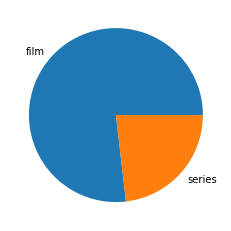

In [9]:
plt.pie((items_df['content_type']).value_counts(), labels=items_df['content_type'].value_counts().index)

In [10]:
train_part.head()

user_id  item_id last_watch_dt  total_dur  watched_pct
0   176549     9506    2021-05-11     4250.0         72.0
1   699317     1659    2021-05-29     8317.0        100.0
2   656683     7107    2021-05-09       10.0          0.0
3   864613     7638    2021-07-05    14483.0        100.0
4   964868     9506    2021-04-30     6725.0        100.0

In [11]:
print(train_part['item_id'][train_part['item_id'].duplicated()], train_part['user_id'][train_part['user_id'].duplicated()])
#проверил количество повторяющихся user id и item id. таким образом убедился, что каждый айтем имеет больше 1 просмотра и каждый юзер посмотрел
#более 1 фильма. можно предположить, что выборка равномерна

4           9506
37         10440
39         10440
43         13865
56          1819
           ...  
1224555    15297
1224556    16373
1224557    15739
1224558    10954
1224559     4151
Name: item_id, Length: 1212493, dtype: int64 649        589939
1006       809980
1049       809980
1262       555233
1331       555233
            ...  
1224553    345193
1224554    160336
1224556     63645
1224558     32937
1224559    311112
Name: user_id, Length: 765461, dtype: int64


In [12]:
merged_data = pd.merge(train_part, items_df, on='item_id')
merged_data = pd.merge(merged_data, users_df, on='user_id')
merged_data = pd.get_dummies(merged_data, columns=['content_type', 'age', 'income', 'sex'])
genres_binarized  = merged_data['genres'].str.get_dummies(', ')
merged_data = pd.concat([merged_data, genres_binarized], axis=1)
merged_data.drop(['genres','title', 'title_orig', 'countries', 'directors', 'actors', 'description', 'keywords', 'studios'], axis=1, inplace=True)

In [13]:
merged_data.head()

user_id  item_id last_watch_dt  total_dur  watched_pct  release_year  \
0   176549     9506    2021-05-11     4250.0         72.0        2013.0   
1   176549     7626    2021-06-17        7.0          0.0        2018.0   
2   176549    11345    2021-06-17      154.0          3.0        2017.0   
3   176549     6626    2021-06-02      100.0          2.0        2020.0   
4   176549    10605    2021-06-04     8415.0        100.0        2016.0   

   for_kids  age_rating  kids_flg  content_type_film  ...  фильмы  фильмы hbo  \
0       NaN         0.0         0               True  ...       0           0   
1       NaN        16.0         0               True  ...       0           0   
2       NaN        18.0         0               True  ...       0           0   
3       NaN        16.0         0               True  ...       0           0   
4       NaN         6.0         0               True  ...       0           0   

   фильмы-спектакли  фитнес  футбол  фэнтези  хочу всё знать  шоу  \
0                 0       0       0        1               0    0   
1                 0       0       0        0               0    0   
2                 0       0       0        0               0    0   
3                 0       0       0        0               0    0   
4                 0       0       0        0               0    0   

   экранизации  юмор  
0            0     0  
1            0     0  
2            0     0  
3            0     0  
4            0     0  

[5 rows x 117 columns]

In [39]:
merged_data.describe()

user_id        item_id                  last_watch_dt  \
count  9.947640e+05  994764.000000                         994764   
mean   5.492018e+05    8456.122138  2021-06-07 10:57:42.291759872   
min    0.000000e+00       0.000000            2021-03-13 00:00:00   
25%    2.749270e+05    4285.000000            2021-05-09 00:00:00   
50%    5.500435e+05    8663.000000            2021-06-16 00:00:00   
75%    8.221190e+05   12623.000000            2021-07-10 00:00:00   
max    1.097557e+06   16518.000000            2021-07-31 00:00:00   
std    3.164977e+05    4744.799323                            NaN   

          total_dur    watched_pct   release_year      for_kids  \
count  9.947640e+05  994556.000000  994690.000000  20832.000000   
mean   7.989593e+03      48.361980    2015.455924      0.046419   
min    1.000000e+00       0.000000    1916.000000      0.000000   
25%    3.700000e+02       4.000000    2013.000000      0.000000   
50%    3.210000e+03      38.000000    2018.000000      0.000000   
75%    7.227000e+03     100.000000    2020.000000      0.000000   
max    6.147245e+06     100.000000    2021.000000      1.000000   
std    3.102331e+04      42.593737       8.340640      0.210396   

          age_rating       kids_flg            18+  ...         фильмы  \
count  994764.000000  994764.000000  994764.000000  ...  994764.000000   
mean       14.456909       0.334391       0.000002  ...       0.000374   
min         0.000000       0.000000       0.000000  ...       0.000000   
25%        12.000000       0.000000       0.000000  ...       0.000000   
50%        16.000000       0.000000       0.000000  ...       0.000000   
75%        18.000000       1.000000       0.000000  ...       0.000000   
max        21.000000       1.000000       1.000000  ...       1.000000   
std         4.564947       0.471777       0.001418  ...       0.019334   

          фильмы hbo  фильмы-спектакли         фитнес         футбол  \
count  994764.000000     994764.000000  994764.000000  994764.000000   
mean        0.000183          0.000017       0.000259       0.000031   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   
std         0.013525          0.004134       0.016103       0.005582   

             фэнтези  хочу всё знать            шоу    экранизации  \
count  994764.000000   994764.000000  994764.000000  994764.000000   
mean        0.105238        0.000197       0.000024       0.000205   
min         0.000000        0.000000       0.000000       0.000000   
25%         0.000000        0.000000       0.000000       0.000000   
50%         0.000000        0.000000       0.000000       0.000000   
75%         0.000000        0.000000       0.000000       0.000000   
max         1.000000        1.000000       1.000000       1.000000   
std         0.306860        0.014035       0.004912       0.014319   

                юмор  
count  994764.000000  
mean        0.000181  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
std         0.013450  

[8 rows x 101 columns]

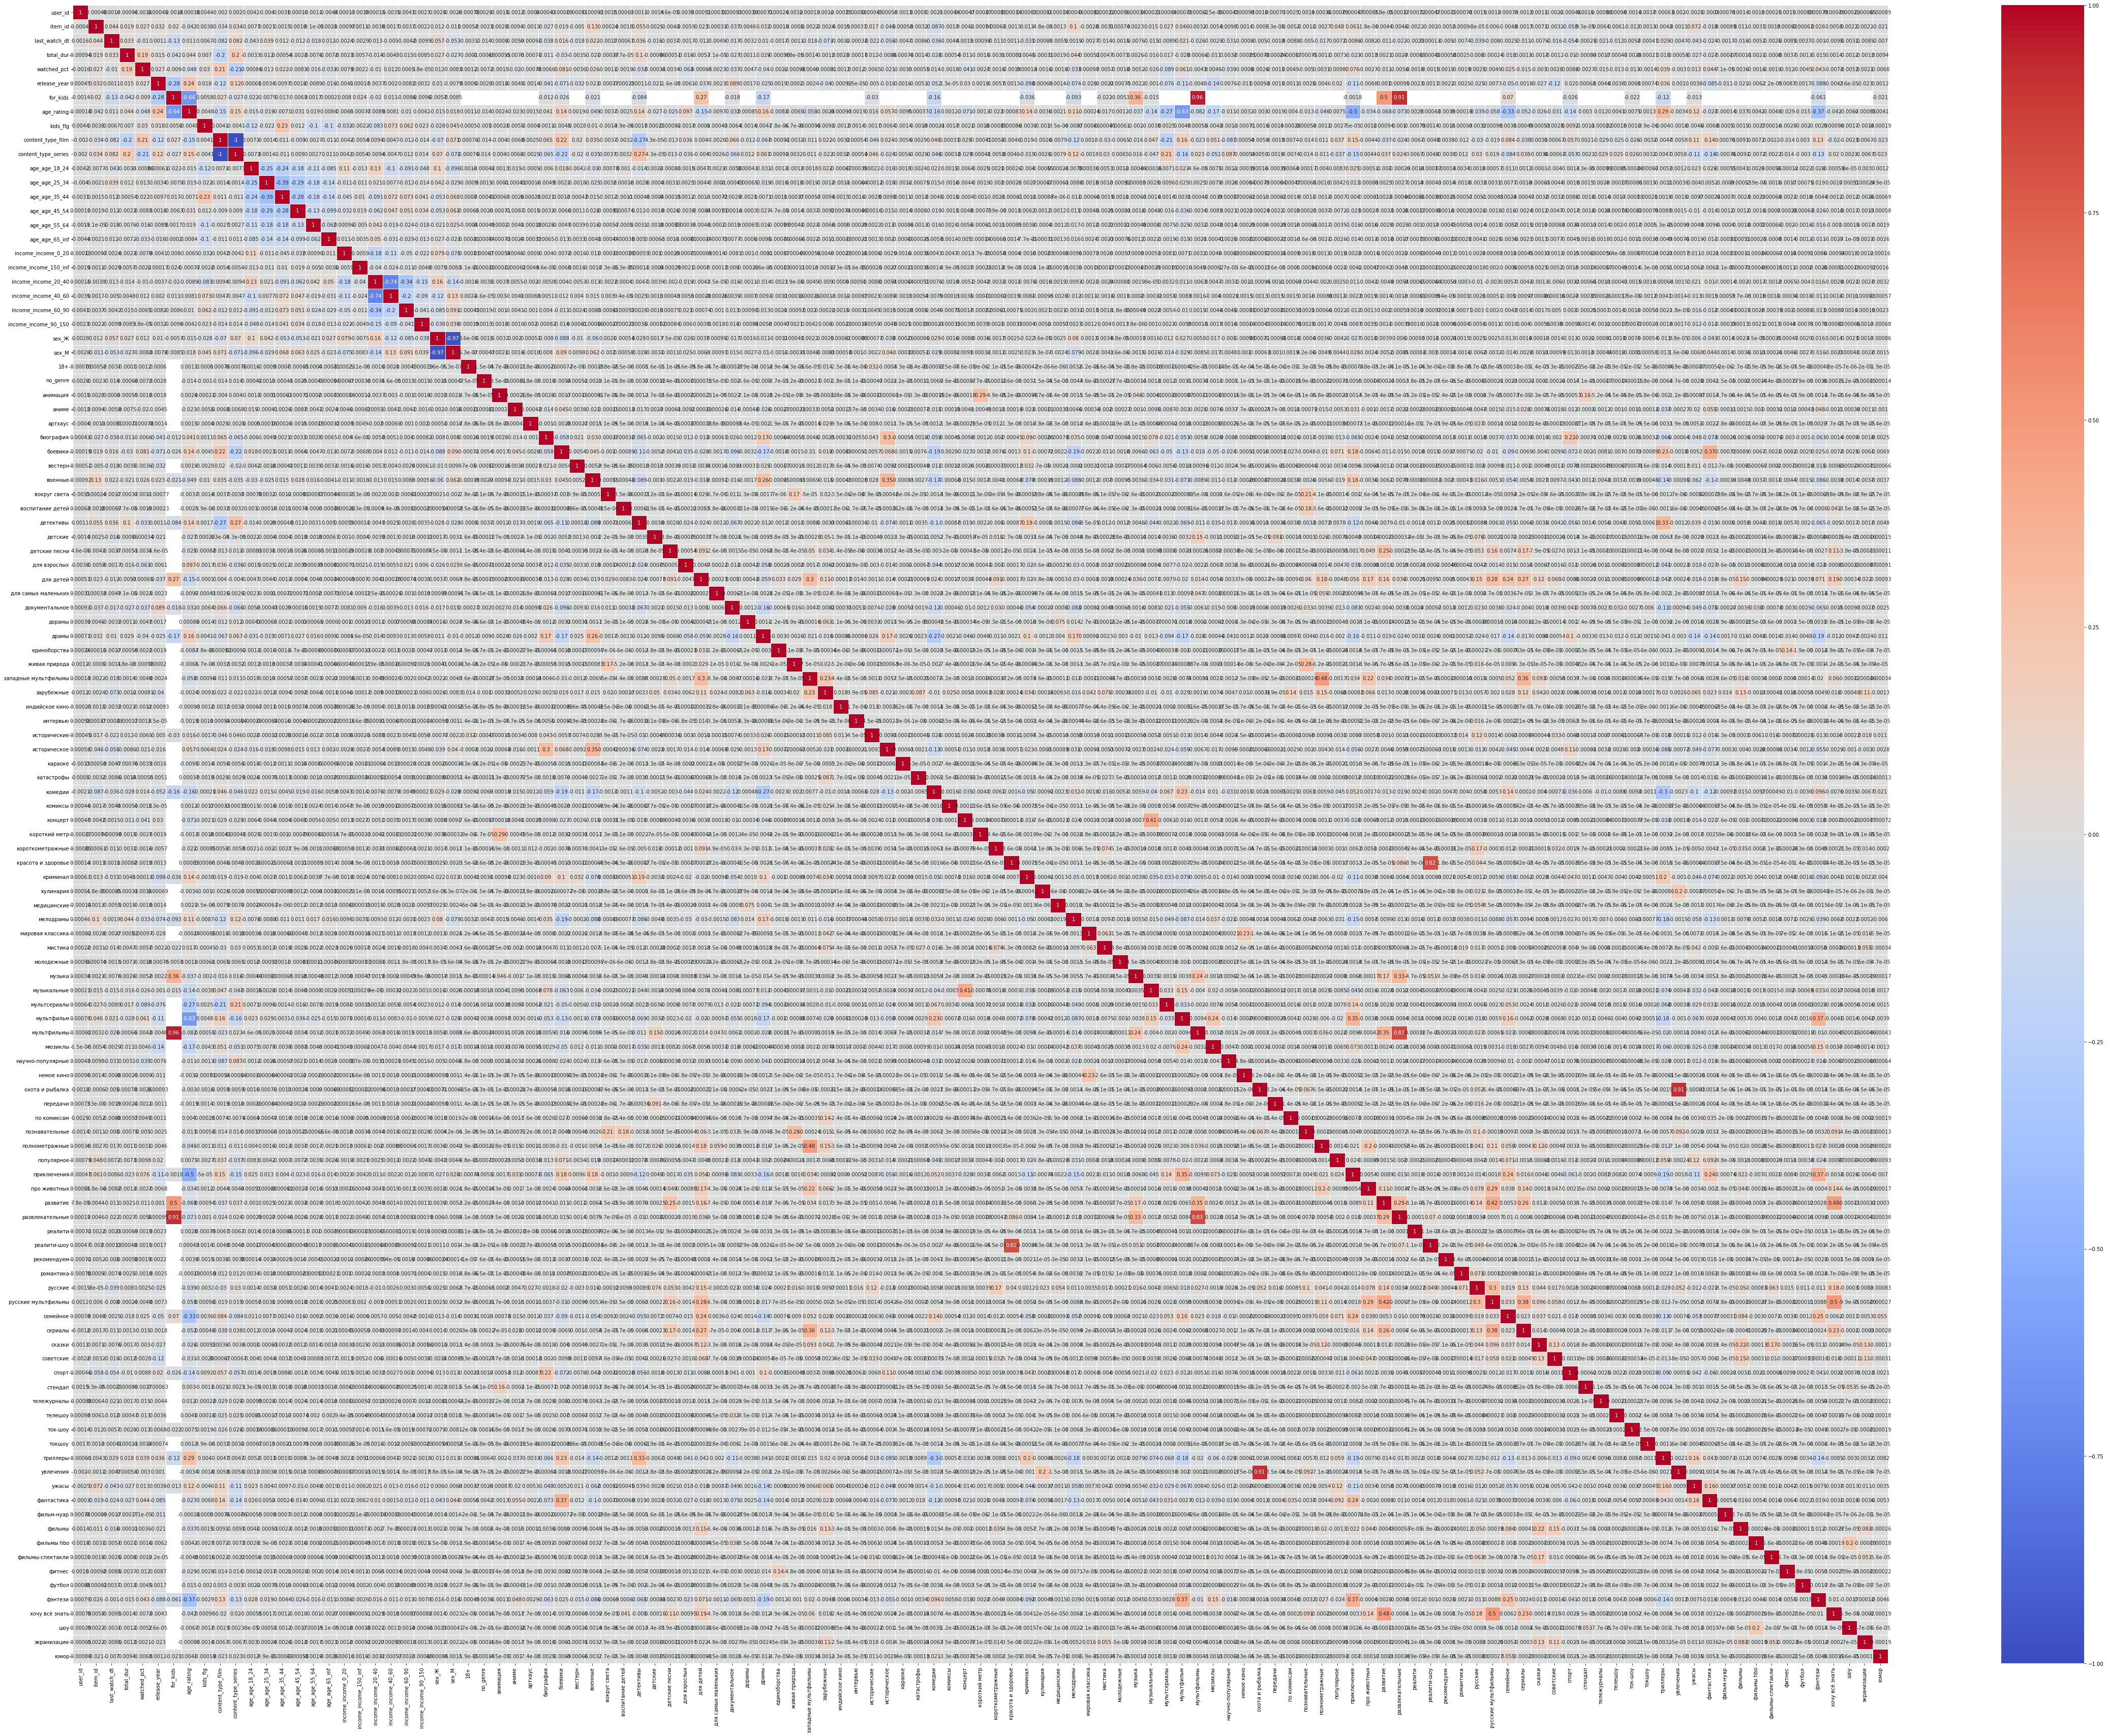

In [14]:
correlation_matrix = merged_data.corr()
plt.figure(figsize=(80, 60))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()
# значения корреляции в столбцах watched pct и total dur (из всех имеющихся данных именно время и процент просмотра, на мой взгляд, объективнее показывают, понравился фильм или нет)
# показывают какие жанры в основном досматривают (хотя влияние жанра на процент просмотра и не очень велико), а еще показывают, что фильмы досматривают чаще , чем сериалы

метрики

In [15]:
def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    ndcg_ = rank_dcg / ideal_dcg
    return ndcg_

def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt

def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []
    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )
    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

класс

In [16]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False
    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        self.trained = True
    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

топ по просмотрам

In [30]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()
    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True
    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)
toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

user_id                                  ground_truth  \
0       30                           [8584, 3031, 15363]   
1      144                          [3800, 11987, 10942]   
2      241                    [14841, 6162, 5808, 15266]   
3      259  [16509, 10509, 4491, 5434, 4471, 10772, 817]   
4      475                            [6214, 3734, 6686]   

                                     toppopular_recs  \
0  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
1  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
2  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
3  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
4  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   

                                            als_recs  
0  [2657, 15297, 10440, 9996, 4880, 4151, 12173, ...  
1  [3734, 9728, 142, 10440, 15297, 11237, 14741, ...  
2  [15297, 10440, 2657, 9996, 4880, 4151, 13865, ...  
3  [15297, 10440, 13865, 2657, 4151, 4880, 9728, ...  
4  [9728, 3734, 13865, 15297, 10440, 142, 11237, ...

In [34]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")

{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

Топ фильмов по просмотрам (досмотренные)

In [62]:
class TopPopularMod(BaseRecommender):
    def __init__(self):
        super().__init__()
    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id", watched_pct: float = 'watched_pct', film: bool = 'content_type_film') -> None:
        # считаем популярность айтемов         
        self.recommendations = df[(df[watched_pct] > 99)&df[film] == True][item_id_col].value_counts().index.values
        self.trained = True
    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)
toppopmod = TopPopularMod()
toppopmod.fit(merged_data)
test_part["toppopularmod_recs"] = toppopmod.predict(test_part)
test_part.head()

user_id                                  ground_truth  \
0       30                           [8584, 3031, 15363]   
1      144                          [3800, 11987, 10942]   
2      241                    [14841, 6162, 5808, 15266]   
3      259  [16509, 10509, 4491, 5434, 4471, 10772, 817]   
4      475                            [6214, 3734, 6686]   

                                     toppopular_recs  \
0  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
1  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
2  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
3  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   
4  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...   

                                            als_recs  \
0  [2657, 15297, 10440, 9996, 4880, 4151, 12173, ...   
1  [3734, 9728, 142, 10440, 15297, 11237, 14741, ...   
2  [15297, 10440, 2657, 9996, 4880, 4151, 13865, ...   
3  [15297, 10440, 13865, 2657, 4151, 4880, 9728, ...   
4  [9728, 3734, 13865, 15297, 10440, 142, 11237, ...   

                                  toppopularmod_recs  \
0  [13865, 9728, 3734, 142, 8636, 11237, 6809, 18...   
1  [13865, 9728, 3734, 142, 8636, 11237, 6809, 18...   
2  [13865, 9728, 3734, 142, 8636, 11237, 6809, 18...   
3  [13865, 9728, 3734, 142, 8636, 11237, 6809, 18...   
4  [13865, 9728, 3734, 142, 8636, 11237, 6809, 18...   

                               toppopularmerged_recs  
0  [15297, 13865, 10440, 9728, 3734, 4151, 142, 8...  
1  [15297, 13865, 10440, 9728, 3734, 4151, 142, 8...  
2  [15297, 13865, 10440, 9728, 3734, 4151, 142, 8...  
3  [15297, 13865, 10440, 9728, 3734, 4151, 142, 8...  
4  [15297, 13865, 10440, 9728, 3734, 4151, 142, 8...

In [63]:
evaluate_recommender(df=test_part, model_preds_col="toppopularmod_recs")

{'ndcg': 0.1177101383080854, 'recall': 0.04933388014566944}

ALS

In [20]:
class ALS(BaseRecommender):
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False
    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values
        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)
        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)
        self.trained = True
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        all_recs = []
        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))
        return all_recs

In [47]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [22]:
evaluate_recommender(test_part, model_preds_col="als_recs")

{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

EDA ALS

In [23]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["item_id"])
first_items = (
    first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.bar(first_items, 0)
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()

In [24]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)]["title"]

In [25]:
get_similar_films("Гнев человеческий")

1120            Мертвые не умирают
3710                 Голос мастера
4070                        Тренер
4509                  Юность Петра
6013             Отстреливая собак
6284     Вселенная Стивена Хокинга
6589            Алиса в Зазеркалье
10036         Убийство на Мидл Бич
10293                  Потрепанные
10338                     Всё могу
Name: title, dtype: object

CBR (тут должна была быть модель, в которой рекомендации основаны на жанрах тех фильмов, которые пользователь посмотрел, но она не работает😢)

In [118]:
data = pd.merge(train_part, items_df, on='item_id')
data = pd.merge(merged_data, users_df, on='user_id')
data['genres']=data['genres'].str.split(', ').str[0] #тут я решил, что первый жанр в списке и является остальным, поэтому остальные можно убрать
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class CBR(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.item_features = None
        self.trained = False

    def fit(self, df: pd.DataFrame, item_feature: str='genres') -> None:
        tfidf_vectorizer = TfidfVectorizer()
        item_features = df[item_feature]
        self.item_features = tfidf_vectorizer.fit_transform(item_features)

    def predict(self, df: pd.DataFrame, user_id: str='user_id', topn: int = 10) -> List[np.ndarray]:
        tfidf_vectorizer = TfidfVectorizer()
        user_profile_features = tfidf_vectorizer.transform(df[user_id])

        cosine_similarities = linear_kernel(user_profile_features, self.item_features)

        topn_indices = cosine_similarities.argsort(axis=1)[:, ::-1][:, :topn]

        topn_item_ids = [data.iloc[idx]['item_id'].values for idx in topn_indices]

        return topn_item_ids

KeyError: 'genres'

In [116]:
cbr_rec = CBR()
cbr_rec.fit(data)
test_part["cbr_recs"] = cbr_rec.predict(test_part)

KeyError: 'genres'

In [ ]:
evaluate_recommender(test_part, model_preds_col="cbr_recs")